In [1]:
import datarobot as dr
import pandas as pd

In [2]:
dr.Client(config_path='./drconfig.yaml')

In [3]:
for p in dr.Project.list():
    print(p.id, p.project_name)

6845d87141f52d1328cf18b5 Auto MPG DR-Client
6845d71fa05ad2afbacf0d91 Python wine quality 2025-06-09
6845a60d47cd8293e1cf0840 Auto MPG DR-Client


In [4]:
project_id = '6845a60d47cd8293e1cf0840'
project = dr.Project.get(project_id)
print(project)

Project(Auto MPG DR-Client)


In [5]:
models = project.get_models()
for m in models:
    print(m.id, m.model_type)

C:\Users\ss81312\AppData\Local\Temp\ipykernel_29680\66731113.py:1: DataRobotDeprecationWarning: `get_models` has been marked for change in `3.4`, will be changed in `4.0`. In 4.0, the flag `use_new_models_retrieval` will be always `True`.
         Fewer attributes will be returned in the response, see the docstring for more details. 
  models = project.get_models()


6845a676dd0bf1e3ab60b3b1 Generalized Additive2 Model
6845a75d468409e60580c6f6 Light Gradient Boosting on ElasticNet Predictions 
6845a676dd0bf1e3ab60b3b3 Light Gradient Boosting on ElasticNet Predictions 
6845a676dd0bf1e3ab60b3af Ridge Regressor
6845a676dd0bf1e3ab60b3b2 Light Gradient Boosted Trees Regressor  (4 leaves)
6845a676dd0bf1e3ab60b3b4 RandomForest Regressor
6845a676dd0bf1e3ab60b3b6 eXtreme Gradient Boosted Trees Regressor
6845a676dd0bf1e3ab60b3b0 Elastic-Net Regressor (mixing alpha=0.5 / Least-Squares Loss)
6845a676dd0bf1e3ab60b3b5 RuleFit Regressor


### Get the recommended model

In [7]:
recommended_model = dr.ModelRecommendation.get(project_id).get_model()
print(recommended_model.id, recommended_model.model_type)

6845a75d468409e60580c6f6 Light Gradient Boosting on ElasticNet Predictions 


In [9]:
# Get one model from the list of all models
model = models[0]

# Print the RMSE metric for the model
model.metrics['RMSE']

{'validation': 3.06691,
 'crossValidation': 3.344532,
 'holdout': None,
 'training': None,
 'backtestingScores': None,
 'backtesting': None}

In [11]:

metric_type = 'RMSE'
for m in models:

    if m.metrics[metric_type]['crossValidation']==None:
        try:
            dr.Model.cross_validate(m)
            print(f'Cross Validating for {m.model_type} in project {project.project_name}')
            print('')
        except dr.errors.ClientError:
            pass
            print(f'All CV scores have been uploaded for the project')
            print()
        
# Update the model list
models = project.get_models()


Cross Validating for RandomForest Regressor in project Auto MPG DR-Client

Cross Validating for eXtreme Gradient Boosted Trees Regressor in project Auto MPG DR-Client

Cross Validating for Elastic-Net Regressor (mixing alpha=0.5 / Least-Squares Loss) in project Auto MPG DR-Client

Cross Validating for RuleFit Regressor in project Auto MPG DR-Client



C:\Users\ss81312\AppData\Local\Temp\ipykernel_29680\2007787999.py:15: DataRobotDeprecationWarning: `get_models` has been marked for change in `3.4`, will be changed in `4.0`. In 4.0, the flag `use_new_models_retrieval` will be always `True`.
         Fewer attributes will be returned in the response, see the docstring for more details. 
  models = project.get_models()


### Gathering info about the models

In [12]:
cv_rmse_scores = pd.DataFrame()

for m in models:
    df = pd.DataFrame([{
        'model_type': m.model_type,
        'model_id': m.id,
        'sample_pct': m.sample_pct,
        'featureList': m.featurelist_name,
        'cross_val_RMSE': m.metrics['RMSE']['crossValidation'] 
    }])
    cv_rmse_scores = pd.concat([cv_rmse_scores, df], axis=0, ignore_index=True)

cv_rmse_scores

C:\Users\ss81312\AppData\Local\Temp\ipykernel_29680\2049052683.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cv_rmse_scores = pd.concat([cv_rmse_scores, df], axis=0, ignore_index=True)


,model_type,model_id,sample_pct,featureList,cross_val_RMSE
0,Generalized Additive2 Model,6845a676dd0bf1e3ab60b3b1,63.889,Informative Features,3.344532
1,Light Gradient Boosting on ElasticNet Predicti...,6845a75d468409e60580c6f6,100.000,Informative Features,3.078658
2,Light Gradient Boosting on ElasticNet Predicti...,6845a676dd0bf1e3ab60b3b3,63.889,Informative Features,2.969524
3,Ridge Regressor,6845a676dd0bf1e3ab60b3af,63.889,Informative Features,2.988600
4,Light Gradient Boosted Trees Regressor (4 lea...,6845a676dd0bf1e3ab60b3b2,63.889,Informative Features,3.007106
5,RandomForest Regressor,6845a676dd0bf1e3ab60b3b4,63.889,Informative Features,NaN
6,eXtreme Gradient Boosted Trees Regressor,6845a676dd0bf1e3ab60b3b6,63.889,Informative Features,NaN
7,Elastic-Net Regressor (mixing alpha=0.5 / Leas...,6845a676dd0bf1e3ab60b3b0,63.889,Informative Features,NaN
8,RuleFit Regressor,6845a676dd0bf1e3ab60b3b5,63.889,Informative Features,NaN


### View Feature Impacts

In [13]:
max_num_features = 15
wait_for_impact = 4*60 # seconds

try:
    # if feature impacts have already been computed
    feature_impacts = recommended_model.get_feature_impact()
except dr.errors.ClientError as e:
    assert e.status_code == 404
    impact_job = recommended_model.request_feature_impact()
    feature_impacts = impact_job.get_result_when_complete(max_wait=wait_for_impact)

feature_impacts.sort(key = lambda x: x['impactNormalized'], reverse=True)
FeatureImpactDF = pd.DataFrame([{
    'Feature Name': f['featureName'],
    'Impact Normalized': f['impactNormalized']
} for f in feature_impacts[:max_num_features]])


In [14]:
FeatureImpactDF

,Feature Name,Impact Normalized
0,weight,1.000000
1,model year,0.463768
2,displacement,0.141466
3,horsepower,0.080401
4,origin,0.068158
5,cylinders,0.031710
6,acceleration,0.022802


<Axes: xlabel='Impact Normalized', ylabel='X_axis'>

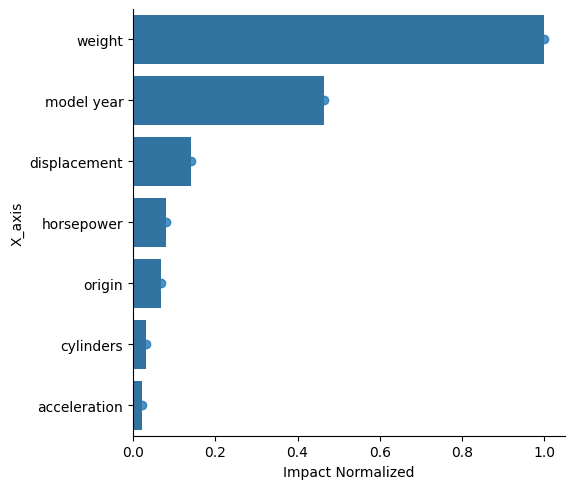

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Graph of feature impact based on impactNormalized
FeatureImpactDF['X_axis'] = FeatureImpactDF.index
g = sns.lmplot(x='Impact Normalized', y='X_axis', data=FeatureImpactDF, fit_reg=False)
sns.barplot(y=FeatureImpactDF['Feature Name'], x=FeatureImpactDF['Impact Normalized'])

### View Feature Effects

In [16]:
# The options for source are: training, validation and holdout
feature_effects = recommended_model.get_or_request_feature_effect(source='validation')

feature_effects

FeatureEffects(project_id=6845a60d47cd8293e1cf0840,model_id=6845a75d468409e60580c6f6, source=validation, data_slice_id=None,backtest_index=None, feature_effects=[{'feature_name': 'weight', 'feature_impact_score': 1.0, 'feature_type': 'numeric', 'partial_dependence': {'is_capped': True, 'data': [{'label': '1832.2', 'dependence': 31.209625570602075}, {'label': '1841.4', 'dependence': 31.151016283042793}, {'label': '1891', 'dependence': 30.835038015222548}, {'label': '1937.6', 'dependence': 30.538171751484043}, {'label': '1950', 'dependence': 30.459177184528983}, {'label': '1965', 'dependence': 30.36361909527593}, {'label': '1975', 'dependence': 30.299913809726984}, {'label': '1985', 'dependence': 30.23620852417804}, {'label': '1991', 'dependence': 30.197985159733108}, {'label': '2019', 'dependence': 30.01961042456792}, {'label': '2043', 'dependence': 29.86671761050674}, {'label': '2050.6', 'dependence': 29.920953777548995}, {'label': '2071.6', 'dependence': 30.049754791011324}, {'label':

In [17]:
fe_variable = feature_effects.feature_effects[1]

Text(0, 0.5, 'Target : (MPG)')

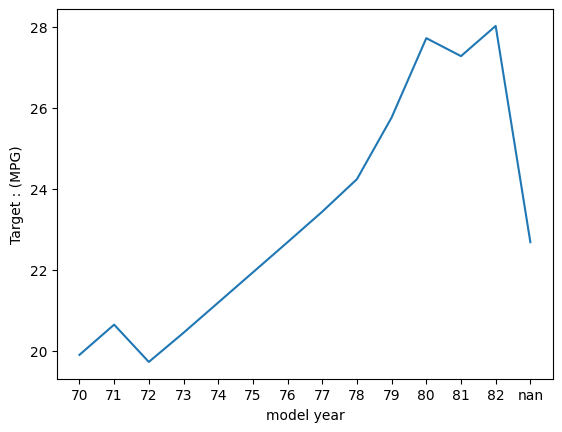

In [21]:
fe_variable_df = pd.DataFrame(fe_variable['partial_dependence']['data'])
sns.lineplot(x = "label", y = "dependence", data=fe_variable_df)
plt.xlabel(fe_variable['feature_name'])
plt.ylabel('Target : (MPG)')

In [23]:
fe_variable_df.shape[0]

14